In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from rom_am import POD, ROM, QUAD_MAN, DMDc, solid_ROM
import time

In [2]:
tr_disp_data = []
tr_load_data = []
test_disp_data = []
test_load_data = []

cutoff = 425
end_incr = 750
num_of_params = 4
include_subiters = True

tr_first_iters = []
tr_converged_iters = [] 
flat_tr_converged_iters = [] 
flat_tr_first_iters = [] 

tst_first_iters = []
tst_converged_iters = []
flat_tst_converged_iters = [] 
flat_tst_first_iters = [] 

param_map = []
tst_param_map = []

#folder_names = ["../Double_E10/10/", "../Double_E10/12/", "../Double_E10/14/"]
folder_names = ["../Double_E10/10/", ]

num_of_params = len(folder_names)

j = 0
k = 0
l = 0
m = 0
n = 0
o = 0

for i in range(num_of_params):
    iters = np.load(folder_names[i]+"/coSimData/iters.npy")[:cutoff]
    iters[0] -= 1
    param_map.append(np.arange(0, iters.sum())+j)
    
    iters_tst = np.load(folder_names[i]+"/coSimData/iters.npy")[cutoff:end_incr]
    tst_param_map.append(np.arange(0, iters_tst.sum())+o)

    tr_first_iters.append(np.append(0, iters[:-1].cumsum().astype(int)))
    tr_converged_iters.append((iters.cumsum()-1).astype(int))
    flat_tr_converged_iters.append(tr_converged_iters[-1]+ k)
    flat_tr_first_iters.append(tr_first_iters[-1]+ l)

    tst_first_iters.append(np.append(0, iters_tst[:-1].cumsum().astype(int)))
    tst_converged_iters.append((iters_tst.cumsum()-1).astype(int))
    flat_tst_converged_iters.append(tst_converged_iters[-1]+ m)
    flat_tst_first_iters.append(tst_first_iters[-1]+ n)
    
    if include_subiters:
        tr_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, :tr_converged_iters[-1][-1]+1])
        tr_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, :tr_converged_iters[-1][-1]+1])

        test_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tr_converged_iters[-1][-1]+1:
                                                                                  tst_converged_iters[-1][-1]+1+tr_converged_iters[-1][-1]+1])
        test_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tr_converged_iters[-1][-1]+1:
                                                                                  tst_converged_iters[-1][-1]+1+tr_converged_iters[-1][-1]+1])

    else:            
        tr_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tr_converged_iters[-1]])
        tr_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tr_converged_iters[-1]])
        
        test_disp_data.append(np.load(folder_names[i]+"/coSimData/disp_data.npy")[:, tst_converged_iters[-1]])
        test_load_data.append(np.load(folder_names[i]+"/coSimData/load_data.npy")[:, tst_converged_iters[-1]])
        
    j += iters.sum()
    o += iters_tst.sum()
    k += tr_converged_iters[-1][-1]
    l += tr_first_iters[-1][-1]
    m += tst_converged_iters[-1][-1]
    n += tst_first_iters[-1][-1]

tr_disp_data = np.concatenate(tr_disp_data, axis=1)
tr_load_data = np.concatenate(tr_load_data, axis = 1)
test_disp_data = np.concatenate(test_disp_data, axis=1)
test_load_data = np.concatenate(test_load_data, axis = 1)
flat_tr_converged_iters = np.concatenate((flat_tr_converged_iters))

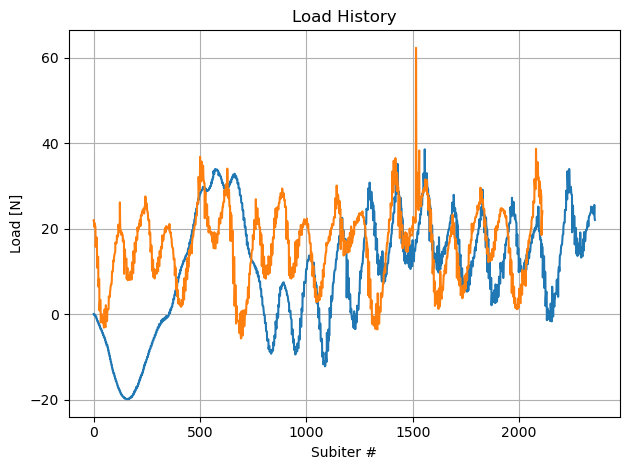

In [3]:
if include_subiters:
    plt.plot(tr_load_data[20, :]);
    plt.plot(test_load_data[20, :]);
    plt.xlabel("Subiter #");
else:
    
    plt.plot(np.arange(0., num_of_params*cutoff), tr_load_data[20, :]);
    plt.plot(np.arange(num_of_params*cutoff, num_of_params*end_incr), test_load_data[20, :]);
    plt.xlabel("Increment #");

plt.ylabel("Load [N]");
plt.title("Load History");

plt.grid();
plt.tight_layout();

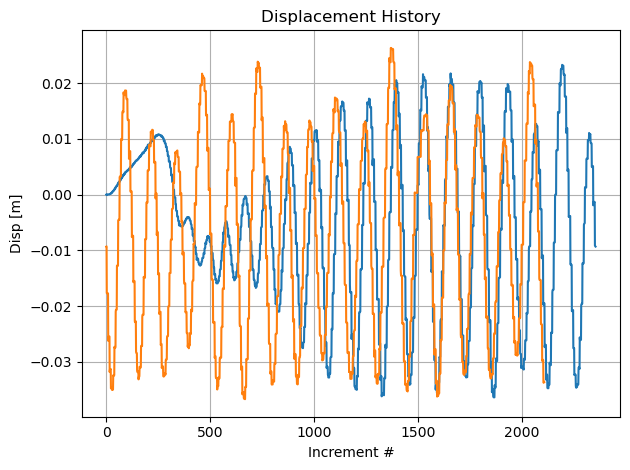

In [4]:
if include_subiters:
    plt.plot(tr_disp_data[20, :]);
    plt.plot(test_disp_data[20, :]);
    plt.xlabel("Subiter #");
else:
    plt.plot(np.arange(0., num_of_params*cutoff), tr_disp_data[20, :]);
    plt.plot(np.arange(num_of_params*cutoff, num_of_params*end_incr), test_disp_data[20, :]);
    plt.xlabel("Increment #");
    
plt.xlabel("Increment #");
plt.ylabel("Disp [m]");
plt.title("Displacement History");

plt.grid();
plt.tight_layout();

**Choice of best alpha**

In [5]:
modes_ = np.arange(15, 61, 5).astype(int)

residual_norm  = []
tst_residual_norm  = []
best_coeffs = np.empty((9, len(modes_)))

import random
ids_ = np.arange(0, tr_load_data.shape[1])
TR_ids = np.array(random.sample(range(tr_load_data.shape[1]), int(.95*tr_load_data.shape[1])))
TST_ids = np.setdiff1d(ids_, TR_ids)

TR_load_data = np.delete(tr_load_data, TST_ids, 1)
TR_disp_data = np.delete(tr_disp_data, TST_ids, 1)

TST_load_data = tr_load_data[:, TST_ids]
TST_disp_data = tr_disp_data[:, TST_ids]

t0 = time.time()
for m in range(len(modes_)):

    print(" modes ", m)

    rom_model = solid_ROM()
    rom_model.train(TR_load_data, TR_disp_data, rank_pres=modes_[m], rank_disp=.9999, 
                    regression_model="PolyLasso", norm_regr=[False, False], quad_=True,);

    X = rom_model.saved_prs_cf_tr
    Y = rom_model.saved_disp_cf_tr
    residual_norm.append(np.linalg.norm(rom_model.regressor.predict(X) - Y, ord = 2))

    for j in range(rom_model.disp_pod.kept_rank):
        best_coeffs[j, m] = rom_model.regressor.regr_model["multioutputregressor"].estimators_[j].alpha_
        
    y = rom_model.pred(TST_load_data).T
    yref = TST_disp_data.T

    tst_residual_norm.append(np.linalg.norm(yref - y, ord = 2))
t1 = time.time()
print("Cross validation time is ", t1 - t0, " s")

 modes  0
 modes  1
 modes  2
 modes  3
 modes  4
 modes  5
 modes  6
 modes  7
 modes  8
 modes  9
Cross validation time is  245.97915124893188  s


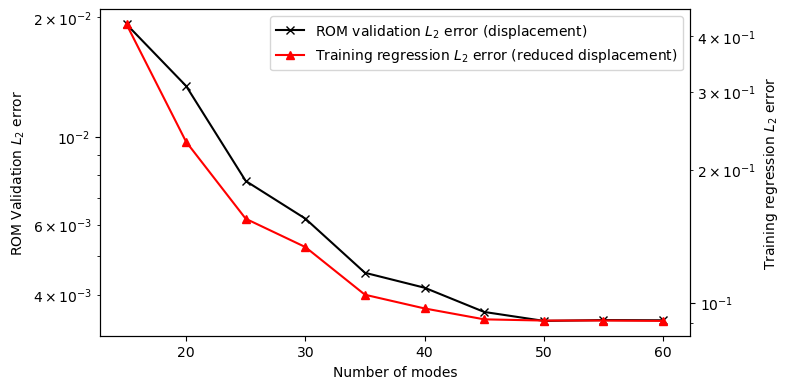

In [6]:
modes_ = np.arange(15, 61, 5).astype(int)
#tst_residual_norm = np.load("../Figures/JFS/v_14_model/test_residuals.npy")
#residual_norm = np.load("../Figures/JFS/v_14_model/residuals.npy")

fig, ax1 = plt.subplots(figsize = (8, 4))

a = ax1.semilogy(modes_, tst_residual_norm, 'x-', label = "ROM validation $L_2$ error (displacement)", color = 'k');
ax1.set_xlabel("Number of modes");
ax1.set_ylabel(r"ROM Validation $L_2$ error");

ax2 = ax1.twinx()
ax2.set_ylabel(r"Training regression $L_2$ error");
b = ax2.semilogy(modes_, residual_norm, '^-', label = "Training regression $L_2$ error (reduced displacement)", color = 'red');

c = a+b
labs = [l.get_label() for l in c]
ax1.legend(c, labs, loc=0)

fig.tight_layout();
#fig.savefig("../Figures/JFS/v_14_model/errors_modes.pdf", bbox_inches = 'tight');
#np.save("../Figures/JFS/v_10_model/residuals.npy", residual_norm)
#np.save("../Figures/JFS/v_10_model/test_residuals.npy", tst_residual_norm)
#np.save("../Figures/JFS/v_10_model/best_coeffs.npy", best_coeffs)

## Constructing the ROM

In [7]:
t0 = time.time()
rom_model = solid_ROM()
rom_model.train(tr_load_data, tr_disp_data, rank_pres=50, rank_disp=.9999,
                norm_regr=[False, False], norm=["l2", "minmax"], quad_=True,  
                map_used = np.load("../coSimData/map_used.npy").T, 
               )
t1 = time.time()
print("Training time is , ", t1 - t0)

Training time is ,  34.09821581840515


In [8]:
"""
import pickle 

with open('./Double_ROM_models/sol_rom_Double_E_10_one_10_lasso_MAP.pkl', 'wb') as outp:

    pickle.dump(rom_model, outp, pickle.HIGHEST_PROTOCOL)
""";

## Showing the polynomial terms activated

In [9]:
ftrs = rom_model.regressor.regr_model["polynomialfeatures"].get_feature_names_out()


Mat = np.zeros((9, rom_model.pres_pod.kept_rank+1, rom_model.pres_pod.kept_rank+1))
for outmode in range(9):
    
    mat = np.zeros((rom_model.pres_pod.kept_rank+1, rom_model.pres_pod.kept_rank+1))
    mat[0, 0] = .5*np.all(rom_model.regressor.regr_model["multioutputregressor"].estimators_[outmode].intercept_)

    for i in range(1, len(ftrs)):
            power = False

            after_x = ftrs[i].split("x",1)[1]
            try:
                first_mode = int(after_x)
                second_mode = -1
            except ValueError:
                try:
                    second_mode = int(after_x.split("x",1)[1])
                    first_mode = int(after_x[:2])
                except IndexError:
                    power = True
                    try:
                        first_mode = int(after_x[:2])
                        second_mode = first_mode
                    except ValueError:
                        first_mode = int(after_x[:1])
                        second_mode = first_mode

            first_mode += 1
            second_mode += 1
            if power:
                mat[first_mode, second_mode] = .5*np.all(rom_model.regressor.regr_model["multioutputregressor"].estimators_[outmode].coef_[i])
            else:
                mat[first_mode, second_mode] = np.all(rom_model.regressor.regr_model["multioutputregressor"].estimators_[outmode].coef_[i])

    mat = (mat+mat.T)
    Mat[outmode, :, :] = mat.copy()

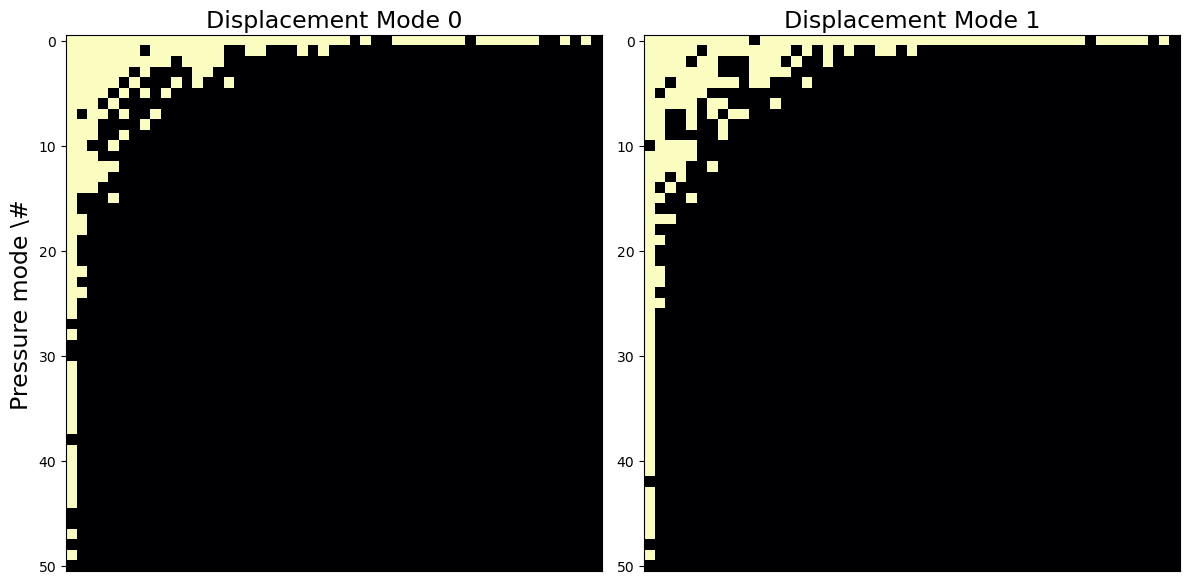

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

out_mode = 0
mat_toplot = Mat[out_mode, :, :]
c = ax[0].matshow(mat_toplot, cmap = 'magma');
ax[0].set_title(r"Displacement Mode "+str(out_mode), fontsize = 17)
ax[0].set_ylabel("Pressure mode \#", fontsize = 17);
ax[0].get_xaxis().set_visible(False)

out_mode = 1
mat_toplot = Mat[out_mode, :, :]
c = ax[1].matshow(mat_toplot, cmap = 'magma');
ax[1].set_title(r"Displacement Mode "+str(out_mode), fontsize = 17)
ax[1].get_xaxis().set_visible(False)

fig.tight_layout();

#fig.savefig("../Figures/JFS/v_10_model/mode_mat_v_10.pdf", bbox_inches = 'tight');

## Singular Value Decay

In [11]:
pod1 = POD()
rom1 = ROM(pod1)
rom1.decompose(tr_load_data, rank = .9999, normalize = True, center = True)

pod2 = POD()
rom2 = ROM(pod2)
rom2.decompose(tr_disp_data, rank = 0, normalize = True, center = True)

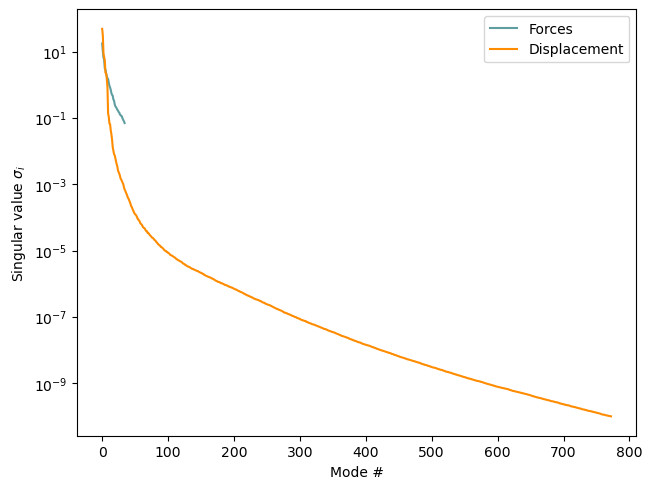

In [12]:
plt.semilogy(pod1.singvals, '-', color = 'cadetblue', label = "Forces");
plt.semilogy(pod2.singvals, '-', color = 'darkorange', label = "Displacement")
plt.legend();
plt.tight_layout();
plt.xlabel("Mode #");
plt.ylabel(r"Singular value $\sigma_i$");
#plt.savefig("SvdFlap.pdf", bbox_inches = 'tight');

## Post processing

In [20]:
import pyvista

In [15]:
# To be used if no mapping is given to the ROM training
"""
predicted_disp = rom_model.pred(test_load_data)
fig = plt.figure(figsize = (12, 4));
abs_err = np.linalg.norm(test_disp_data - predicted_disp, axis = 0)
rel_err = abs_err / np.linalg.norm(test_disp_data, axis = 0)
plt.plot(100 * rel_err,);
plt.ylabel("[%]");
plt.ylim(top=4., bottom = 0.);
plt.tight_layout();
plt.grid();
""";

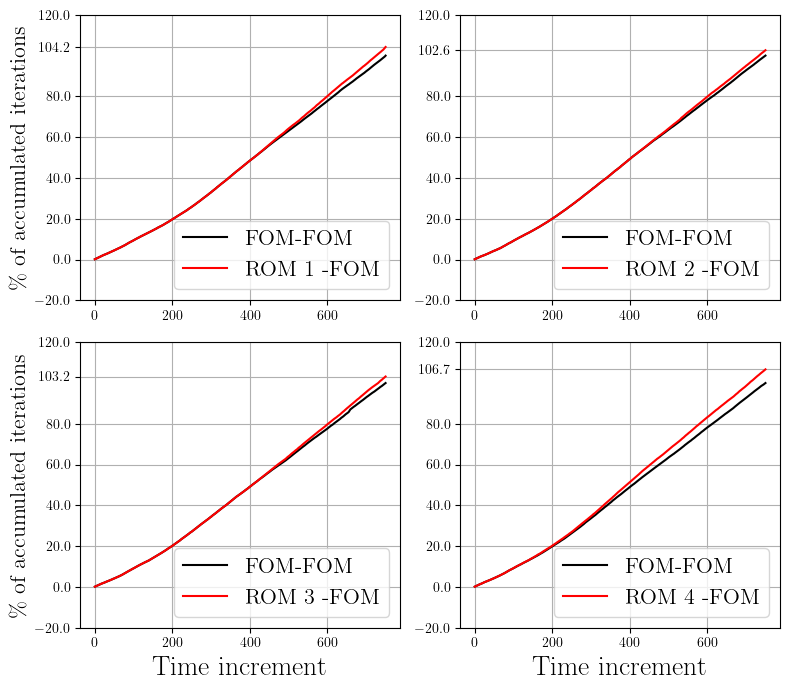

In [16]:
import matplotlib
matplotlib.rc('text', usetex=True)
plt.rcParams["font.family"] = "Times New Roman"


fig, ax = plt.subplots(2, 2, figsize = (8, 7) );

fom_iters = np.load("../Double_E10/14/coSimData/iters.npy")
rom_iters = np.load("../Double_ROM_E10/14_LASSO/coSimData/iters.npy")
last_ = (100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1])[-1]

ax[0, 0].plot(100*np.cumsum(fom_iters)/np.cumsum(fom_iters)[-1], color = 'k', label = 'FOM-FOM');
ax[0, 0].plot(100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1], color = 'red', label = 'ROM 1 -FOM');
x_ticks = np.append(np.setdiff1d(ax[0, 0].get_yticks(), 100.), last_)
ax[0, 0].set_yticks(x_ticks)

#ax[0, 0].xlabel(r"Time increment", fontsize = 20);
ax[0, 0].set_ylabel(r"\% of accumulated iterations", fontsize = 16);
ax[0, 0].legend(fontsize = 16, loc = 'lower right',);
ax[0, 0].grid();
plt.tight_layout();

fom_iters = np.load("../Double_E10/12/coSimData/iters.npy")
rom_iters = np.load("../Double_ROM_E10/12_LASSO/coSimData/iters.npy")
last_ = (100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1])[-1]

ax[0, 1].plot(100*np.cumsum(fom_iters)/np.cumsum(fom_iters)[-1], color = 'k', label = 'FOM-FOM');
ax[0, 1].plot(100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1], color = 'red', label = 'ROM 2 -FOM');
x_ticks = np.append(np.setdiff1d(ax[0, 1].get_yticks(), 100.), last_)
ax[0, 1].set_yticks(x_ticks)

#ax[0, 0].xlabel(r"Time increment", fontsize = 20);
ax[0, 1].legend(fontsize = 16, loc = 'lower right',);
ax[0, 1].grid();

fom_iters = np.load("../Double_E10/10/coSimData/iters.npy")
rom_iters = np.load("../Double_ROM_E10/10_LASSO/coSimData/iters.npy")
last_ = (100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1])[-1]

ax[1, 0].plot(100*np.cumsum(fom_iters)/np.cumsum(fom_iters)[-1], color = 'k', label = 'FOM-FOM');
ax[1, 0].plot(100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1], color = 'red', label = 'ROM 3 -FOM');
x_ticks = np.append(np.setdiff1d(ax[1, 0].get_yticks(), 100.), last_)
ax[1, 0].set_yticks(x_ticks)

ax[1, 0].set_xlabel(r"Time increment", fontsize = 20);
ax[1, 0].set_ylabel(r"\% of accumulated iterations", fontsize = 16);
ax[1, 0].legend(fontsize = 16, loc = 'lower right',);
ax[1, 0].grid();


fom_iters = np.load("../Double_E10/13/coSimData/iters.npy")
rom_iters = np.load("../Double_ROM_E10/13_LASSO/coSimData/iters.npy")
last_ = (100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1])[-1]

ax[1, 1].plot(100*np.cumsum(fom_iters)/np.cumsum(fom_iters)[-1], color = 'k', label = 'FOM-FOM');
ax[1, 1].plot(100*np.cumsum(rom_iters)/np.cumsum(fom_iters)[-1], color = 'red', label = 'ROM 4 -FOM');
x_ticks = np.append(np.setdiff1d(ax[1, 1].get_yticks(), 100.), last_)
ax[1, 1].set_yticks(x_ticks)

ax[1, 1].set_xlabel(r"Time increment", fontsize = 20);
ax[1, 1].legend(fontsize = 16, loc = 'lower right',);
ax[1, 1].grid();

plt.tight_layout();
#fig.savefig("iters_doubleflap_other.eps", bbox_inches = 'tight');

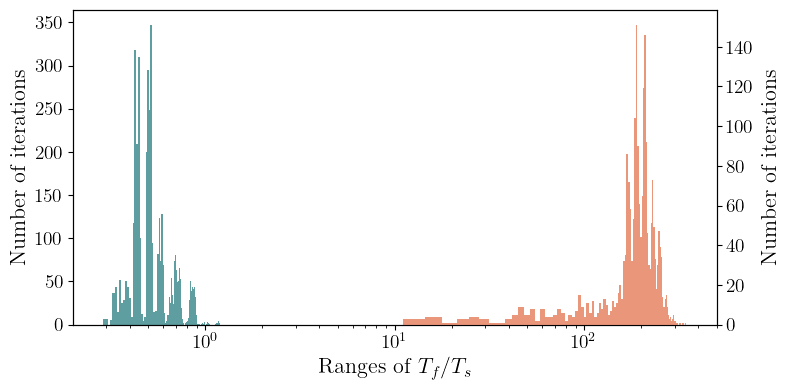

In [17]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

last_rom_iter = np.load("../Double_ROM_E10/14_LASSO/coSimData/iters.npy").cumsum()[425]

fig, ax1 = plt.subplots(figsize = (8, 4))

aa = np.load("../Double_E10/14/coSimData/fluid_time.npy")/np.load("../Double_E10/14/coSimData/structure_time.npy")
bb = np.load("../Double_ROM_E10/14_LASSO/coSimData/fluid_time.npy")/np.load("../Double_ROM_E10/14_LASSO/coSimData/structure_time.npy")
_, _, c = ax1.hist(reject_outliers(aa), bins = 100, color = 'cadetblue', label = 'FOM-FOM');
plt.xscale('log')
ax2 = ax1.twinx()
_, _, d = ax2.hist(reject_outliers(bb[last_rom_iter:]), bins = 100, color = 'darksalmon', label = 'ROM-FOM');
e = c+d

labs = [l.get_label() for l in e]
#ax2.legend(e, labs, loc ='upper center', fontsize = 15);
ax1.set_xlabel(r"Ranges of $T_f/T_s$", fontsize = 16);
ax1.tick_params(axis='both', which='major', labelsize = 14);
ax2.tick_params(axis='both', which='major', labelsize = 14);
ax1.set_ylabel("Number of iterations", fontsize = 16);
ax2.set_ylabel("Number of iterations", fontsize = 16);

fig.tight_layout();
#fig.savefig("solver_ratios_full.pdf", bbox_inches = 'tight');

## Solid Speedup

In [18]:
v = "12" #Viscosity
rom_fiter = 425
fom_fiD = np.cumsum(np.load("../Double_E10/"+v+"/coSimData/iters.npy"))[rom_fiter]
rom_fiD = np.cumsum(np.load("../Double_ROM_E10/"+v+"_LASSO/coSimData/iters.npy"))[rom_fiter]

fom_sol_time = reject_outliers(np.load("../Double_E10/"+v+"/coSimData/structure_time.npy")[fom_fiD:])
rom_sol_time = reject_outliers(np.load("../Double_ROM_E10/"+v+"_LASSO/coSimData/structure_time.npy")[rom_fiD:])
avg_speedup = (fom_sol_time.mean()/rom_sol_time.mean())
print(avg_speedup)

183.64064960214398


## Total Speedup

In [19]:
v = "12" #Viscosity
rom_fiter = 425
fom_fiD = np.cumsum(np.load("../Double_E10/"+v+"/coSimData/iters.npy"))[rom_fiter]
rom_fiD = np.cumsum(np.load("../Double_ROM_E10/"+v+"_LASSO/coSimData/iters.npy"))[rom_fiter]

recons_time_arr = np.load("../Double_ROM_E10/"+v+"_LASSO/coSimData/structure_recons_time.npy")
if len(recons_time_arr)==1:
    recons_time = recons_time_arr[0]
else:
    recons_time = recons_time_arr.sum()
    

fom_time = np.load("../Double_E10/"+v+"/coSimData/total_solving_time.npy") - (
    np.load("../Double_E10/"+v+"/coSimData/increment_time.npy")[:rom_fiter].sum())
rom_time =  recons_time + np.load("../Double_ROM_E10/"+v+"_LASSO/coSimData/total_solving_time.npy") - (
    np.load("../Double_ROM_E10/"+v+"_LASSO/coSimData/increment_time.npy")[:rom_fiter].sum())

if v == "12":
    rom_time -= 14

ratioIs = fom_time/rom_time
print(ratioIs)

[1.88012529]


## Displacement results

Node with Id 1488 corresponds to the left-most node
Node with Id 0 corresponds to the right-most node

In [21]:
v = "14" # Viscosity
dt = .008
msh = pyvista.read("../Double_E10/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_1.vtk")

displacement_X = np.empty((msh.points.shape[0], 751))
displacement_Y = np.empty((msh.points.shape[0], 751))
time = np.arange(0, 751)*dt
for i in range(751):
    msh = pyvista.read("../Double_E10/"+v+"/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")

    displacement_X[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y[:, i] = msh.point_data["DISPLACEMENT"][:, 1]

displacement_X_ROM = np.empty((msh.points.shape[0], 751))
displacement_Y_ROM = np.empty((msh.points.shape[0], 751))
for i in range(751):
    msh = pyvista.read("../Double_ROM_E10/"+v+"_LASSO/vtk_data/vtk_output_fsi_csm/Structure_0_"+str(i+1)+".vtk")
    displacement_X_ROM[:, i] = msh.point_data["DISPLACEMENT"][:, 0]
    displacement_Y_ROM[:, i] = msh.point_data["DISPLACEMENT"][:, 1]
    

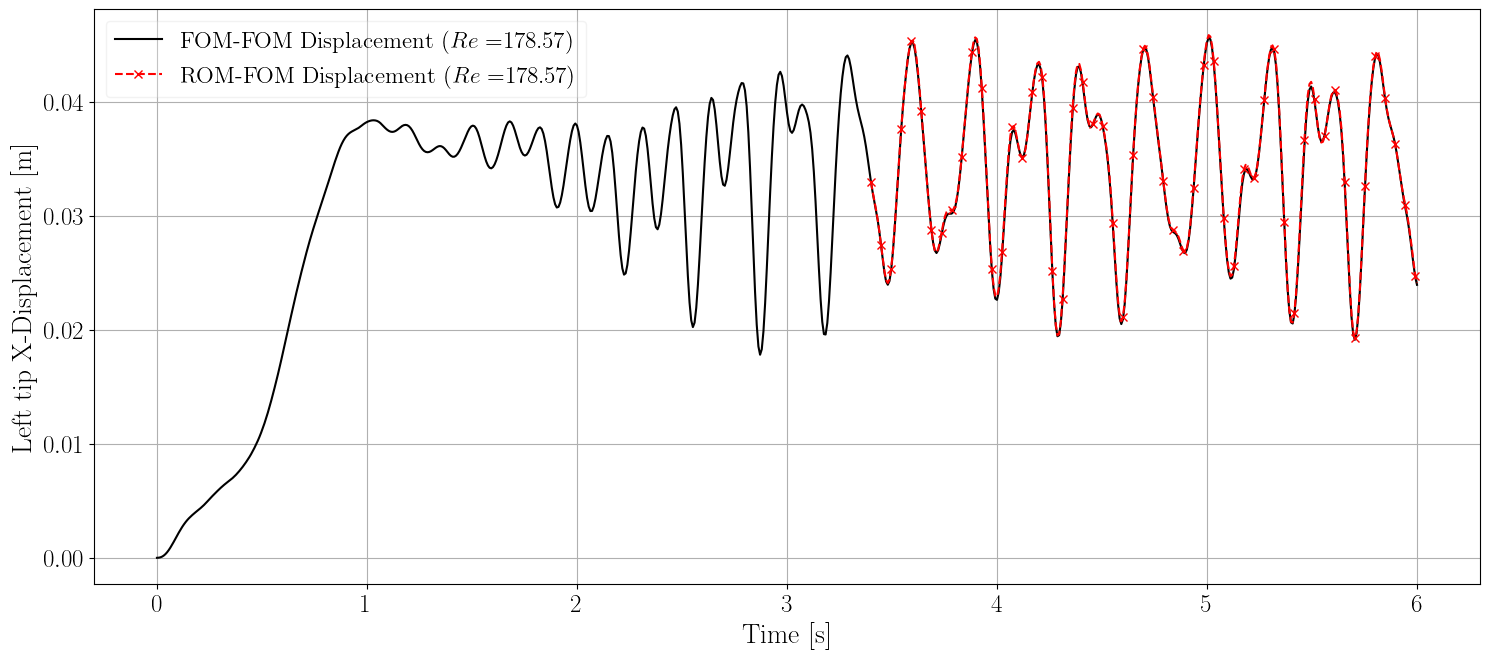

In [22]:
Re = .1*2.5*1000/(float(v)/10)
figure, ax = plt.subplots(figsize = (15, 6.7));
time_arr = np.arange(0, 6., 0.008);
start_pred = 425
if v == "13" or v == "08.3":
    start_pred = 100
    
#plt.plot(time_arr[:375], disps_x_tr[4, :375], '--', color = 'orange', label = r'FOM-FOM Displacement - $Re = 250$ (Training)');
#plt.plot(time_arr[374:569], disps_x_tr[4, 374:569], '--', color = 'deepskyblue', label = r'FOM-FOM Displacement - $Re = 250$');
plt.plot(time, displacement_X[1488, :], 'black', label = r'FOM-FOM Displacement ($Re = $'+"%.2f" %Re+')',);
plt.plot(time[start_pred:], displacement_X_ROM[1488, start_pred:], 'x--',  markevery = 6, color = 'red', 
         label = r'ROM-FOM Displacement ($Re = $'+"%.2f" %Re+')',);

ax.set_xlabel("Time [s]", fontsize = 20);
ax.set_ylabel("Left tip X-Displacement [m]", fontsize = 20);

ax.tick_params(axis='both', which='major', labelsize = 18)
ax.tick_params(axis='both', which='minor', labelsize = 18)

legend = plt.legend(loc = 'best', framealpha = .25,  prop={'size': 16.8})
#frame = legend.get_frame()
#frame.set_color('white')
plt.grid();
plt.tight_layout();

#plt.savefig("rom_fom_tip.pdf", transparent = True, bbox_inches = 'tight');